In [1]:
import csv
import math
import statistics
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
import scipy

In [2]:
expression_path = '/home/aaron/projects/proteogenomics/R-3.5.3/bin/bad_samples_expression_001/RT-Loess-normalized.txt'

In [3]:
data = []

with open(expression_path) as expression_file:
    reader = csv.DictReader(expression_file, delimiter='\t')
    for row in reader:
        data.append(row)

In [4]:
for row in data:
    row['peptide_charge'] = row['peptide'] + '_' + row['charge']

In [5]:
headers = ['sample']
headers += [row['peptide_charge'] for row in data]

In [6]:
samples = {'Yutaka_P1905_021': {}, 
           'Yutaka_P1905_022': {},
           'Yutaka_P1905_023': {},
           'Yutaka_P1905_018': {},
           'Yutaka_P1905_019': {},
           'Yutaka_P1905_020': {}}

In [7]:
for row in data:
    for key, header in row.items():
        if key in samples:
            if row[key] == "NA":
                row[key] = 0.0
            samples[key][row['peptide_charge']] = float(row[key])

In [8]:
for sample, data in samples.items():
    data['sample'] = sample

In [9]:
def scale_data(data):
    data_min = min(data)
    data_max = max(data)
    data_mean = statistics.mean(data)
    stdev = statistics.stdev(data)
    return data_min, data_max, data_mean, stdev

In [10]:
def scale_quant(data_point, key, scale_map):
    scaled_count = (data_point - scale_map[key][2]) / (scale_map[key][1] - scale_map[key][0])
    return scaled_count

In [11]:
all_peptide_features = {}

for key in headers:
    if key != "sample":
        
        if key not in all_peptide_features:
            all_peptide_features[key] = []
        for sample, quant_data in samples.items():
            all_peptide_features[key].append(quant_data[key])

            
scaled_metrics = {}

eliminated_peptides = set()

all_stdev = []

for peptide_key, data in all_peptide_features.items():
    if 0 not in data:
        scaled_data_metrics = scale_data(data)
        if scaled_data_metrics[3] < 1.0:
            eliminated_peptides.add(peptide_key)
        all_stdev.append(scaled_data_metrics[3])
    scaled_metrics[peptide_key] = scale_data(data)

In [12]:
with open('stdev.tsv', 'w') as std_file:
    writer = csv.writer(std_file)
    writer.writerow(['stdev'])
    for stdev in all_stdev:
        writer.writerow([stdev])

In [10]:
outfile = 'reformatted.tsv'

with open(outfile, 'w') as ofile:
    writer = csv.DictWriter(ofile, delimiter='\t', fieldnames=headers)
    writer.writeheader()
    for sample, data in samples.items():
        writer.writerow(data)

In [129]:
training_data = []

sample_order = []

for sample, data in samples.items():
    temp = []
    for key, feature in data.items():
        if key != 'sample':
            if key not in eliminated_peptides:
                scaled_data = scale_quant(feature, key, scaled_metrics)
                temp.append(scaled_data)
    training_data.append(temp)
    
    sample_order.append(sample)

In [130]:
linkage_matrix = linkage(training_data, 'complete')

In [131]:
linkage_matrix[0]

array([ 2.        ,  5.        , 10.65792255,  2.        ])

In [132]:
linkage_matrix
from matplotlib import colors



In [133]:
test = colors.to_rgb("lightcoral")

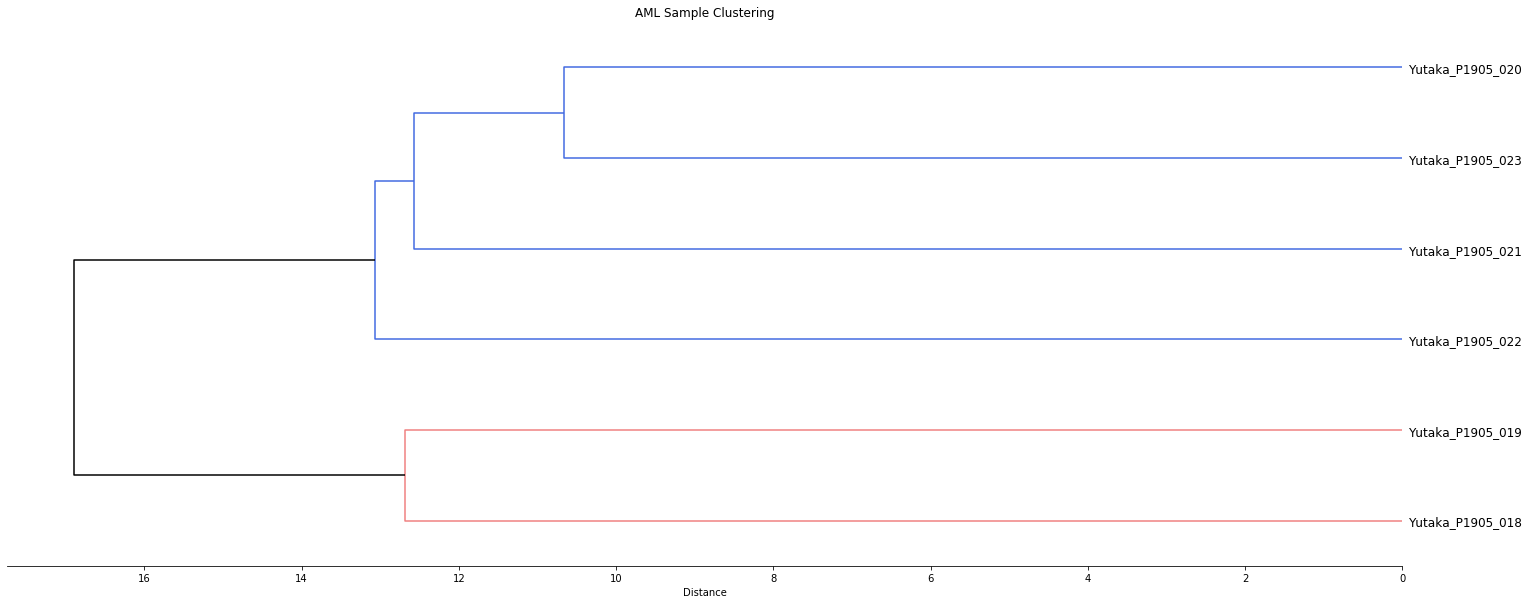

In [134]:
scipy.cluster.hierarchy.set_link_color_palette(['lightcoral', 'royalblue', 'y', 'm'])
plt.style.use("seaborn-muted")
fig, axes = plt.subplots(1, 1, figsize=(25, 10))


axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['left'].set_visible(False)

plt.title('AML Sample Clustering')
plt.xlabel('Distance')
dn = dendrogram(
    linkage_matrix,
    leaf_rotation=0,  # rotates the x axis labels# font size for the x axis labels
    orientation='left',
    labels=sample_order,
    above_threshold_color='k',
    color_threshold=15
)

plt.gcf()
plt.savefig('aml_sample_clustering.png', dpi=fig.dpi, bbox_inches='tight')
plt.show()

In [115]:
plt.gcf()
plt.savefig('aml_sample_clustering.png', dpi=fig.dpi)

<Figure size 432x288 with 0 Axes>

In [116]:
from scipy import cluster